# Auto complete the skill point maximizer forms

## OCR of skill hints (test)

In [1]:
import pytesseract
from PIL import Image

img = Image.open('test.png')
img = img.convert('RGB')
size = img.size

border = 750
for x in range(size[0]):
  for y in range(size[1]):
    r,g,b = img.getpixel((x,y))
    if r + g + b > border:
      r, g, b = 255, 255, 255
    else:
      r, g, b = 0, 0, 0
    img.putpixel((x,y), (r,g,b))

img.show()

txt = pytesseract.image_to_string(img,lang='jpn')
txt = txt.replace(' ', '')
print(txt)

ヒントLv2
20%0FF

ヒントLv1
10%O0FF



## Preliminary

In [1]:
BLACK = 0
WHITE = 255

### Display function

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def imgshow(src):
  if type(src) is list:
    list_src = src
  else:
    list_src = [src]
  fig = plt.figure(figsize = (8*len(list_src), 16))
  for i, img in enumerate(list_src, 1):
    ax = fig.add_subplot(1, len(list_src), i)
    if img.ndim == 2: # gray scale
      ax.imshow(img, cmap='gray', vmin=0, vmax=255)
    elif img.shape[2] == 3: # BGR
      ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    elif img.shape[2] == 4: # BGRA
      ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGBA))

## Analyze images and extract skill hint information

### Determine the margin bottom

#### Display search range

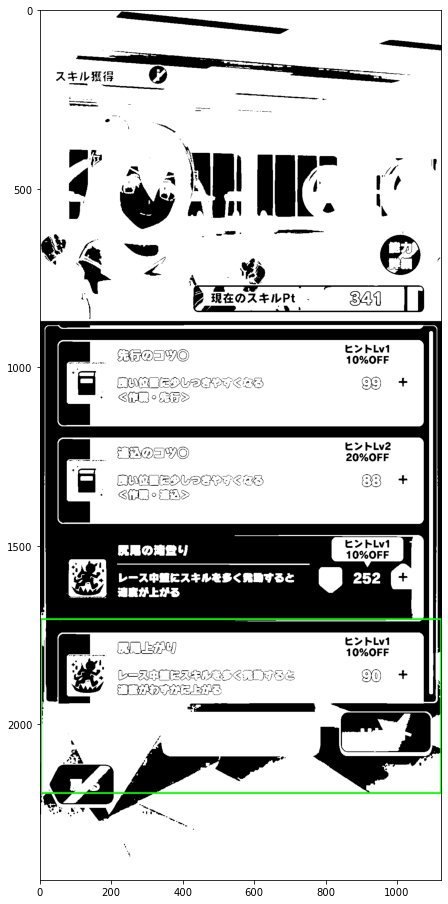

In [16]:
img = cv2.imread('test6.png', cv2.IMREAD_COLOR)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV_FULL)

# digitization thresholds in HSV
min = (0, 0, 0)
max = (255, 255, 245)
inrange = cv2.inRange(hsv, min, max)
height, width = inrange.shape

# green box shows search range
tmp_img = cv2.cvtColor(inrange, cv2.COLOR_GRAY2BGR)
cv2.rectangle(tmp_img, pt1=(3, int(height*0.70)),
  pt2=(tmp_img.shape[1]-3, int(height*0.90)),
  color=(0,255,0), thickness=3)
imgshow(tmp_img)

#### y coordinate detection and display

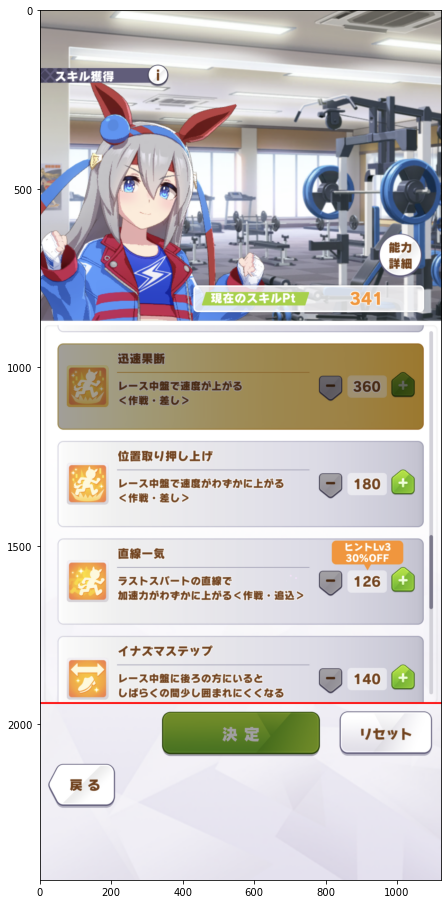

In [15]:
min_ratio = 0.4
max_ratio = 0.7
for y in np.arange(int(height*0.7), int(height*0.9)):
  cts = np.count_nonzero(inrange[y, :] == BLACK)
  ratio = cts / width
  if min_ratio < ratio and ratio < max_ratio:
    margin_bottom = y-1
    break

tmp_img = img.copy()
cv2.line(tmp_img, pt1=(0, margin_bottom), pt2=(width, margin_bottom),
  color=(0, 0, 255), thickness=3)
imgshow(tmp_img)

### Crop image with white background as delimiter

In [30]:
def crop_delim_white(img):

  # average color per row of grayed image is used to judge white BG
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  average_color_per_row = np.average(gray_img, axis=1)
  is_white = average_color_per_row > 240

  # image with white for all skill box regions and black for others
  skill_box_regions = gray_img
  for y in range(len(img)):
    if is_white[y]:
      skill_box_regions[y] = np.full(len(img[0]), 0)
    else:
      skill_box_regions[y] = np.full(len(img[0]), 255)

  # contours of skill box regions
  _, threshold_img = cv2.threshold(skill_box_regions, 180, 255, cv2.THRESH_BINARY)
  contours, _ = cv2.findContours(threshold_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # crop image according to contours
  images = []
  for contour in reversed(contours): # reverse to recover the original ordering
    x, y, w, h = cv2.boundingRect(contour)
    cropped_img = img[y:y+h, x:x+w]
    images.append(cropped_img)
    
  return images

### Judge if gold or normal skill

In [49]:
img = cv2.imread('test.png')
skill_boxes = crop_delim_white(img)

border_gray = 180
border_blue = 180
for skill in skill_boxes:
  gray_skill = cv2.cvtColor(skill, cv2.COLOR_BGR2GRAY)
  if np.median(gray_skill) < border_gray:
    print('取得済み or スキルポイント不足')
  else:
    print('未取得')
    if(np.median(skill[:,:,0]) < border_blue):
      print('金スキル')
    else:
      print('ノーマルスキル')

  cv2.imshow('image', np.array(gray_skill))
  cv2.waitKey()


取得済み
未取得
ノーマルスキル
未取得
ノーマルスキル


### Extract hint level

In [78]:
img = cv2.imread('test3.png')
skill_boxes = crop_delim_white(img)
skill_cv = skill_boxes[0]

gray_skill_cv = cv2.cvtColor(skill_cv, cv2.COLOR_BGR2GRAY)
gray_skill = Image.fromarray(gray_skill_cv)
size = gray_skill.size

border = 253
for x in range(size[0]):
  for y in range(size[1]):
    c = gray_skill.getpixel((x,y))
    if c > border:
      c = 255
    else:
      c = 0
    gray_skill.putpixel((x,y), c)

gray_skill.show()

txt = pytesseract.image_to_string(gray_skill,lang='jpn')
txt = txt.replace(' ', '')
print(txt)

ヒントLv1
102oOFF



## Auto complete skill hints

In [70]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

options = Options()
options.add_argument('--disable-gpu')
options.add_argument('--disable-extensions')
options.add_argument('--proxy-server="direct://"')
options.add_argument('--proxy-bypass-list=*')
options.add_argument('--start-maximized')

DRIVER_PATH = '/usr/local/bin/chromedriver'
driver = webdriver.Chrome(executable_path=DRIVER_PATH, options=options)

load_url = 'https://gamewith.jp/uma-musume/article/show/293663'
driver.get(load_url)

<ipython-input-70-8c7b64c92cfd>:13: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=DRIVER_PATH, options=options)


### 現在のスキルポイントを入力

In [71]:
skill_point = 2000
skill_point_textarea = driver.find_element(By.XPATH, "//input[@id='HavePoint'][@type='number']")
skill_point_textarea.send_keys(str(skill_point))

### 切れ者を取得している

In [72]:
shrewd = True
if shrewd:
  shrewd_checkbox = driver.find_element(By.XPATH, "//label[@for='HasKiremono']")
  shrewd_checkbox.click()

### 適性を入力する

In [73]:
appropriate = [1,4,3,2,1,1,1,2,3,4] # 1 [SA] 2 [BC] 3 [DEF] 4[G]
for count, app in enumerate(appropriate): # grass, dart, sprint, mile, middle, long, front, stalk, stay, off
  id = "//label[@for='AppropriateSelect" + str(count+1) + "_" + str(app) + "']"
  appropriate_radio = driver.find_element(By.XPATH, id)
  appropriate_radio.click()

### 取得しているヒントとレベル

In [74]:
hints = [['VIP顔パス', 2],['アガッてきた！', 4]]
for hint in hints:
  hint_search_textarea = driver.find_element(By.XPATH, "//input[@id='SkillSearchText'][@type='text']")
  hint_search_textarea.clear()
  hint_search_textarea.send_keys(hint[0])
  skill_label = driver.find_element(By.XPATH, '//*[@id="article-body"]/div[3]/div[2]/ol[2]/li/label')
  skill_label.click() # スキルヒントLv.0取得
  hint_up_button = driver.find_element(By.XPATH, '//*[@class="_hint-button is-up"]')
  for i in range(hint[1]): # ヒントLv.設定
    hint_up_button.click()

### 評価点が最大になる組み合わせを計算

In [76]:
maximizer_button = driver.find_element(By.XPATH, '//*[@class="w-start-calculate js-start-calculate"]')
maximizer_button.click()

In [ ]:
# driver.quit()